In [1]:
from io import StringIO

from pathlib import Path
from pydub import AudioSegment
from scipy.io import wavfile

import pydub.playback as pydub_pb
import soundfile as sf
import numpy as np
import pandas as pd
import librosa

In [2]:
sf.available_subtypes('wav')

{'PCM_16': 'Signed 16 bit PCM',
 'PCM_24': 'Signed 24 bit PCM',
 'PCM_32': 'Signed 32 bit PCM',
 'PCM_U8': 'Unsigned 8 bit PCM',
 'FLOAT': '32 bit float',
 'DOUBLE': '64 bit float',
 'ULAW': 'U-Law',
 'ALAW': 'A-Law',
 'IMA_ADPCM': 'IMA ADPCM',
 'MS_ADPCM': 'Microsoft ADPCM',
 'GSM610': 'GSM 6.10',
 'G721_32': '32kbs G721 ADPCM',
 'NMS_ADPCM_16': '16kbs NMS ADPCM',
 'NMS_ADPCM_24': '24kbs NMS ADPCM',
 'NMS_ADPCM_32': '32kbs NMS ADPCM',
 'MPEG_LAYER_III': 'MPEG Layer III'}

[127 127 127 ... 127 127 127]


Matplotlib is building the font cache; this may take a moment.


array([[<Axes: title={'center': 'sample'}>]], dtype=object)

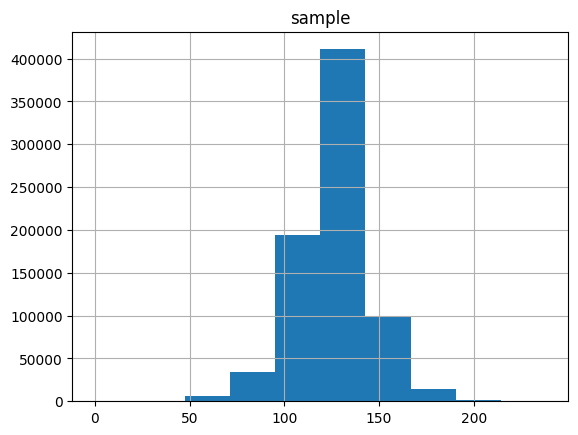

In [88]:
def np_dtype_min(t):
	return np.iinfo(t).min

def np_dtype_max(t):
	return np.iinfo(t).max

def np_rescale(data, out_dtype):
	t_inter = np.float128

	in_min, in_max = t_inter(np_dtype_min(data.dtype)), t_inter(np_dtype_max(data.dtype))
	out_min, out_max = t_inter(np_dtype_min(out_dtype)), t_inter(np_dtype_max(out_dtype))

	inter = (data.astype(t_inter) - in_min) / (in_max - in_min)
	return (out_min + (inter * (out_max - out_min))).astype(out_dtype)

audio_d, audio_sr = sf.read(Path('data/BassonTracker.wav'), dtype='int16')
audio_dn = np_rescale(audio_d, np.uint8)
print(audio_dn)

df = pd.DataFrame(audio_dn, columns=["sample"])
df.hist()

#sf.write('stereo_file.wav', data, samplerate, subtype='PCM_24')

# audio_dn = (audio_d.astype(np.float32) - np.int16.min) / (np.int16.max - np.int16.min)
# audio_dn

In [98]:
from scipy.io import wavfile


array([128, 127, 128, ..., 130, 130, 130], dtype=uint8)

len= 420439
OK


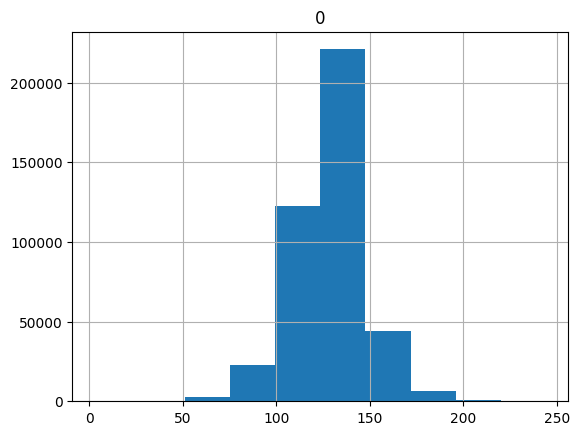

In [18]:
AUDIO="Marlo"
F_SOUND_ORIG_IN = Path(f'data/{AUDIO}.wav')
F_SOUND_8BIT_IN = Path(f"data/{AUDIO}.8bit.wav")
F_SOUND_DATA_IN = Path(f"data/{AUDIO}.data.wav")

F_SOUND_SRC_OUT = Path("/Users/nonlogical/Documents/Arduino/libraries/M5Bala2/src/bala_snd.h")

audio_d, audio_sr = sf.read(F_SOUND_ORIG_IN)

audio_nsr = int(audio_sr/3)
audio_nd = librosa.resample(audio_d, orig_sr=audio_sr, target_sr=audio_nsr)
sf.write(F_SOUND_8BIT_IN, audio_nd, audio_nsr, subtype='PCM_U8')


file_tpl = """
#ifndef __BALA_SND_H
#define __BALA_SND_H

#include "Arduino.h"

#define BALA_SND_SAMPLE_RATE {data_sr}

const uint8_t bala_snd[{data_len}] = {{
{data}
	%TERMINATOR%,
}};

#endif
"""

def bala_snd_encode():
	out_src = F_SOUND_SRC_OUT

	audio_sr, audio_d = wavfile.read(F_SOUND_8BIT_IN)
	# audio_d = (((audio_d.astype(np.float128)- 127) * 0.5) + 127).astype(np.uint8)
	audio_sr = int(audio_sr * 1.3)
	print("len=", len(audio_d))
	wavfile.write(F_SOUND_DATA_IN, audio_sr, audio_d)

	#audio_d = (audio_d*0.5).astype(np.uint8)
	pd.DataFrame(audio_d).hist()

	encoded_c_data = StringIO()
	for i, b in enumerate(audio_d):
		l_begin = i%16 == 0
		l_end = (i+1)%16 == 0
		end = ", "
		prefix = ""
		if l_begin:
			prefix = "    "
		if l_end:
			end = ",\n"
		print("%s0x%s" % (prefix, hex(b)[2:].rjust(2, "0")), end=end, file=encoded_c_data)

	encoded_c_data.seek(0)
	out_file_content = file_tpl.format(
		data=encoded_c_data.read(),
		data_len=len(audio_d)+1,
		data_sr=audio_sr,
	)
	out_file_content = out_file_content.replace("0x00", "0x01")
	out_file_content = out_file_content.replace("%TERMINATOR%", "0x00")
	out_src.write_text(out_file_content)
	print("OK")

bala_snd_encode()

OK
